In [1]:
import pandas as pd
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate


In [2]:
data = pd.read_excel('/Users/ycliu/Desktop/Rice_Osmancik_Cammeo_Dataset.xlsx', engine='openpyxl')

# Normalize the data

In [3]:
for c in data.columns[:-1]:
    data[c] = (data[c] - np.mean(data[c])) / np.std(data[c])

In [4]:
data.head()

,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
0,1.479830,2.004354,2.348547,-0.212943,2.018337,1.499659,-1.152921,Cammeo
1,1.147870,1.125853,0.988390,0.945568,0.410018,1.192918,-0.602079,Cammeo
2,1.135169,1.317214,1.451908,0.253887,1.212956,1.126504,0.405611,Cammeo
3,0.293436,0.115300,0.261439,0.198051,0.239751,0.233857,-0.275351,Cammeo
4,1.166345,1.487053,1.316442,0.523419,0.952221,1.299855,-0.206013,Cammeo


In [5]:
data.value_counts('CLASS')

CLASS
Osmancik    2180
Cammeo      1630
dtype: int64

# PCA

In [6]:
pca = decomposition.PCA(n_components=2)
data_reduced = pca.fit_transform(data[[
    'AREA',
    'PERIMETER',
    'MAJORAXIS',
    'ECCENTRICITY',
    'CONVEX_AREA',
    'EXTENT'
    ]])
pc0 = data_reduced[:, 0]
pc1 = data_reduced[:, 1]

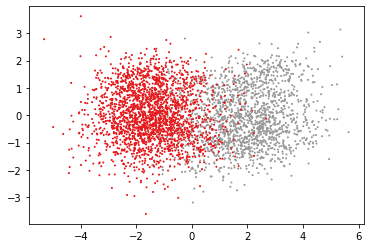

In [7]:
plt.scatter(pc0, pc1, 
    c=data.CLASS.map({'Osmancik': 0, 'Cammeo': 1}),
    s=1, cmap='Set1')
plt.show()

The PCA model is able to reduce the dimensionality of the data to 2. The gaussion distance of two samples seems to be small if they belong to the same class.

# Implementation of the KNN algorithm and Quad Tree

Citation: https://cloud.tencent.com/developer/article/1487842
https://scipython.com/blog/quadtrees-2-implementation-in-python/
https://jrtechs.net/data-science/implementing-a-quadtree-in-python

In [8]:
class Point: #the points in the training set
    def __init__(self, x, y, payload=None):
        self.x, self.y = x, y
        self.payload = payload

    def distance_to(self, other):
        try:
            other_x, other_y = other.x, other.y
        except AttributeError:
            other_x, other_y = other
        return np.hypot(self.x - other_x, self.y - other_y)

class Rect: #Rectangular store the shape and other attribute of the quadtree
    #cx: center point x-axis
    #cy: center point y-axis
    #w: the width of the rectangular
    #h: the height of the rectangular
    def __init__(self, cx, cy, w, h):
        self.cx, self.cy = cx, cy
        self.w, self.h = w, h
        self.west_edge, self.east_edge = cx - w/2, cx + w/2
        self.north_edge, self.south_edge = cy - h/2, cy + h/2

    def contains(self, point): #validate if a point is inside of the rectangular
        try:
            point_x, point_y = point.x, point.y
        except AttributeError:
            point_x, point_y = point

        return (point_x >= self.west_edge and
                point_x <  self.east_edge and
                point_y >= self.north_edge and
                point_y < self.south_edge)

    def intersects(self, other):#validate if the rectangular is in the center and the radius
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

class QuadTree:
    #A class implementing a quadtree.
    #boundary: the rectangular that store the shape and cneter
    #depth: the max number of points can be stored in this quad tree

    def __init__(self, boundary, max_points=4, depth=0):
        self.boundary = boundary
        self.max_points = max_points
        self.points = []
        self.depth = depth
        self.divided = False

    def divide(self): #divide the quad tree into 4 sub quadtree 
        cx, cy = self.boundary.cx, self.boundary.cy
        w, h = self.boundary.w / 2, self.boundary.h / 2
        self.nw = QuadTree(Rect(cx - w/2, cy - h/2, w, h),
                                    self.max_points, self.depth + 1)
        self.ne = QuadTree(Rect(cx + w/2, cy - h/2, w, h),
                                    self.max_points, self.depth + 1)
        self.se = QuadTree(Rect(cx + w/2, cy + h/2, w, h),
                                    self.max_points, self.depth + 1)
        self.sw = QuadTree(Rect(cx - w/2, cy + h/2, w, h),
                                    self.max_points, self.depth + 1)
        self.divided = True

    def insert(self, point): #insert the points into the sub quadtree.
        if not self.boundary.contains(point):
            # The point does not lie inside boundary: bail.
            return False
        if len(self.points) < self.max_points:
            # There's room for our point without dividing the QuadTree.
            self.points.append(point)
            return True

        # No room: divide if necessary, then try the sub-quads.
        if not self.divided:
            self.divide()

        return (self.ne.insert(point) or
                self.nw.insert(point) or
                self.se.insert(point) or
                self.sw.insert(point))

    def query_circle(self, boundary, centre, radius, found_points):
        """Find the points in the quadtree that lie within radius of centre.

        boundary is a Rect object (a square) that bounds the search circle.
        There is no need to call this method directly: use query_radius.

        """

        if not self.boundary.intersects(boundary):
            # If the domain of this node does not intersect the search
            # region, we don't need to look in it for points.
            return False

        # Search this node's points to see if they lie within boundary
        # and also lie within a circle of given radius around the centre point.
        for point in self.points:
            if (boundary.contains(point) and
                    point.distance_to(centre) <= radius):
                found_points.append(point)

        # Recurse the search into this node's children.
        if self.divided:
            self.nw.query_circle(boundary, centre, radius, found_points)
            self.ne.query_circle(boundary, centre, radius, found_points)
            self.se.query_circle(boundary, centre, radius, found_points)
            self.sw.query_circle(boundary, centre, radius, found_points)
        return found_points

    def query_radius(self, centre, radius, found_points):
        """Find the points in the quadtree that lie within radius of centre."""

        boundary = Rect(*centre, 2*radius, 2*radius)
        return self.query_circle(boundary, centre, radius, found_points)


    def __len__(self):
        npoints = len(self.points)
        if self.divided:
            npoints += len(self.nw)+len(self.ne)+len(self.se)+len(self.sw)
        return npoints

In [9]:
class KNN(): #K Neaarest Neighbor algorithm
    def __init__(self, k = 1) -> None:
        self.qtree = QuadTree(Rect(0, 0, 25, 25))
        self.k = k
        self.pca = decomposition.PCA(n_components=2)

    def fit(self, X, y):
        X = self.pca.fit_transform(X)
        for _x, _y in zip(X, y):
            self.qtree.insert(Point(_x[0], _x[1], _y))
    
    def predict(self, X):
        k = self.k
        pred = []
        # binary search for radius
        r_max = 5
        r_min = 0
        while True:
            found_points = []
            r = (r_max + r_min) / 2
            self.qtree.query_radius((X[0], X[1]), r, found_points)
            if len(found_points) > k:
                r_max = r
            elif len(found_points) < k:
                r_min = r
            else:
                break
        for p in found_points:
            pred.append(p.payload)
        return np.bincount(pred).argmax()
    
    def score(self, X, y):
        X = self.pca.transform(X)
        pred = []
        for x in X:
            pred.append(self.predict(x))
        pred = np.array(pred)
        y = np.array(y)
        return confusion_matrix(y, pred)
    
    def get_params(self, *args, **kwargs):
        return dict()

In [10]:
_data = data.sample(frac=1)
X = _data[[
    'AREA',
    'PERIMETER',
    'MAJORAXIS',
    'ECCENTRICITY',
    'CONVEX_AREA',
    'EXTENT'
    ]]
Y = _data.CLASS.map({'Osmancik': 0, 'Cammeo': 1})

When k = 1: 

In [11]:
for i in range(0, len(X), int(len(X)/5)):
    i = int(i)
    x_test = X.iloc[i: i+int(len(X)/5)]
    x_train = X.drop(x_test.index)
    y_test = Y[x_test.index]
    y_train = Y.drop(x_test.index)
    knn = KNN(k=1)
    knn.fit(x_train, y_train)
    print(knn.score(x_test, y_test))


[[386  51]
 [ 53 272]]
[[381  45]
 [ 47 289]]
[[417  34]
 [ 35 276]]
[[377  56]
 [ 46 283]]
[[394  39]
 [ 49 280]]


When k = 5: 

In [12]:
for i in range(0, len(X), int(len(X)/5)):
    i = int(i)
    x_test = X.iloc[i: i+int(len(X)/5)]
    x_train = X.drop(x_test.index)
    y_test = Y[x_test.index]
    y_train = Y.drop(x_test.index)
    knn = KNN(k=5)
    knn.fit(x_train, y_train)
    print(knn.score(x_test, y_test))


[[399  38]
 [ 31 294]]
[[396  30]
 [ 28 308]]
[[427  24]
 [ 28 283]]
[[402  31]
 [ 37 292]]
[[406  27]
 [ 47 282]]


According to confusion matrix definition, we can see the difference of results between when k = 1 and when k = 5. Citation: https://blog.csdn.net/vesper305/article/details/44927047

Obviously, the overall true positive (Osmancik is correctly classified as Osmancik) and true negative (Cammeo is correctly classified as Cammeo) is higher in the results when k = 5 than in the results when k = 1; meanwhile, the overall false positive(Osmancik is wrongly classified as Cammeo) and false negative(Cammeo is wrongly classified as Osmancik) is lower in the results when k = 5 than in the results when k = 1. 

From the result we can see that the consitency of knn when k=5 is better.